In [2275]:
from IPython import get_ipython
from keras import backend as K

In [2276]:
# destroy the current TF graph and create a new one
# useful to avoid clutter from old models/layers
K.clear_session()

cfg=K.tf.ConfigProto()
cfg.gpu_options.allow_growth=True
K.set_session(K.tf.Session(config=cfg))


# clear all variables created
get_ipython().magic('reset -sf')

In [2277]:
import pandas as pd
from pandas import Series
import numpy as np
from numpy import polyfit
from matplotlib import pyplot
import matplotlib as mpl

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.utils import plot_model

import time
import datetime
import math
import keras.callbacks
from keras.callbacks import EarlyStopping
import os
from sklearn.metrics import mean_squared_error,r2_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from scipy.stats.stats import pearsonr
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model

# show chinese in matplot
zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/truetype/arphic/uming.ttf',size=18, weight='bold')

In [2278]:
# location of time series
# location0
#lat=31.375
#lon=126.125

# location1(good)
#lat=32.125
#lon=126.125

#location 2(bad)
lat=31.125
lon=123.875

#location 3(good)
#lat=26.875
#lon=123.125

#location 4(good)
#lat=31.125
#lon=127.125

#location 5(good)
#lat=28.875
#lon=126.125

#location 6(good)
#lat=28.375
#lon=124.125

location='('+str(lat)+'N,'+str(lon)+'E)'
print(location)

# wheter to train or load trained lstm model
# If true, train new model
# If false, load trained model
boolean_train_lstm_model=False

(31.125N,123.875E)


In [2279]:
# create a folder to store results of the location
resultsDir_en='results/'+location+'/en/' # English version
resultsDir_cn='results/'+location+'/cn/' # Chinese version
lstm_rm_seasonality_dir='lstm_rm_seasonality/'
svr_rm_seasonality_dir='svr_rm_seasonality/'

if not os.path.exists(resultsDir_en):
    os.makedirs(resultsDir_en)
    
if not os.path.exists(resultsDir_cn):
    os.makedirs(resultsDir_cn)
    
if not os.path.exists(resultsDir_en+lstm_rm_seasonality_dir):
    os.makedirs(resultsDir_en+lstm_rm_seasonality_dir)

if not os.path.exists(resultsDir_cn+lstm_rm_seasonality_dir):
    os.makedirs(resultsDir_cn+lstm_rm_seasonality_dir)
    
if not os.path.exists(resultsDir_en+svr_rm_seasonality_dir):
    os.makedirs(resultsDir_en+svr_rm_seasonality_dir)
    
if not os.path.exists(resultsDir_cn+svr_rm_seasonality_dir):
    os.makedirs(resultsDir_cn+svr_rm_seasonality_dir)

In [2280]:
sst_file='/home/xiao/data/ncdc_oisst_v2_avhrr_east_china_sea_'+str(lat)+'N_'+str(lon)+'E_19820101-20171231.csv'
series=pd.read_csv(sst_file,sep=';',usecols=[7],engine='python')
dates=pd.read_csv(sst_file,sep=';',usecols=[0],engine='python')

In [2281]:
dates.head()

,time
0,1982-01-01
1,1982-01-02
2,1982-01-03
3,1982-01-04
4,1982-01-05


In [2282]:
series.head()

,sst
0,13.269999
1,13.200000
2,13.130000
3,13.070000
4,13.469999


In [2283]:
series.shape

(13149, 1)

In [2284]:
# save descriptions of the observed SST series to csv file
series_description=series.describe()
series_description.to_csv(resultsDir_en+'series_description.csv')
series_description.to_csv(resultsDir_cn+'series_description.csv')
print(series_description)

                sst
count  13149.000000
mean      18.871838
std        5.770767
min        7.520000
25%       13.219999
50%       19.210000
75%       24.000000
max       30.230000


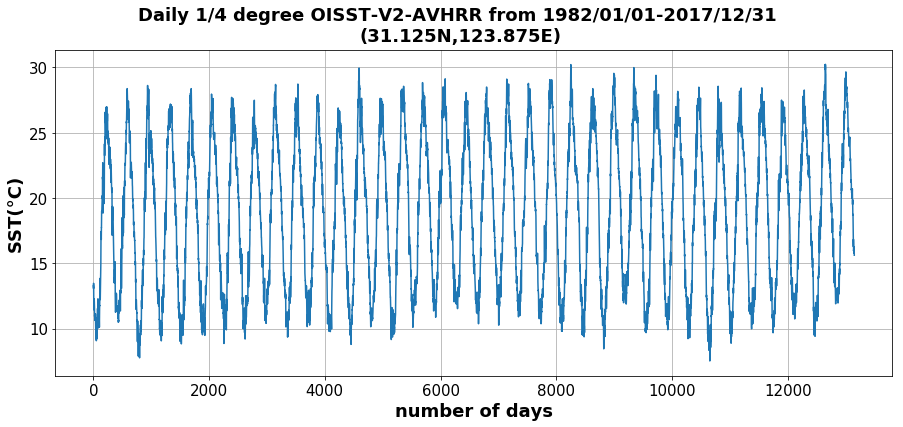

In [2285]:
# plot orignial time series (English version)
n_days=[(i+1) for i in range(len(series.values))]

fig,ax=pyplot.subplots(figsize=(15,6))
fig.suptitle('Daily 1/4 degree OISST-V2-AVHRR from 1982/01/01-2017/12/31 \n'+location,fontsize=18,fontweight='bold')

ax.plot(n_days,series.values)

# set x,y label
ax.set_xlabel(xlabel='number of days',
              fontsize=18,
              fontweight='bold')
ax.set_ylabel(ylabel='SST(\u00B0C)',
              fontsize=18,
              fontweight='bold')
# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
#legend=ax.legend(loc='upper left',fontsize=15,ncol=2)
#legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.825, 1.18))

# save fig
fig.savefig(resultsDir_en+'Time series of actual SST'+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()

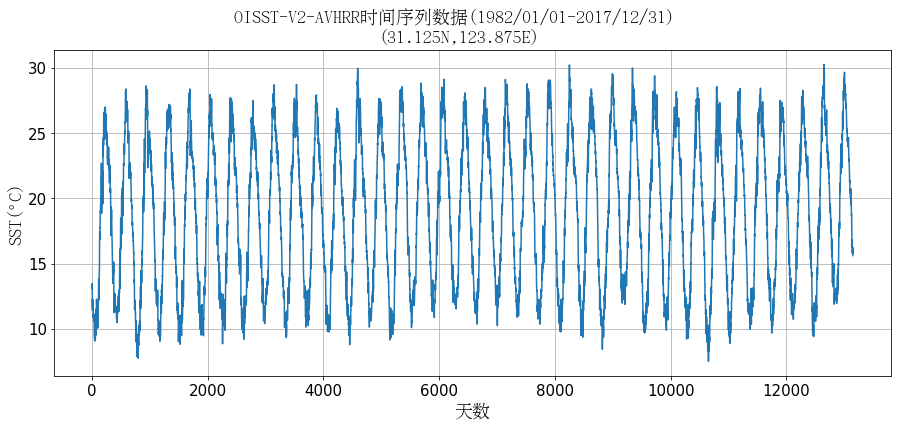

In [2286]:
# plot orignial time series (Chinese version)
n_days=[(i+1) for i in range(len(series.values))]

fig,ax=pyplot.subplots(figsize=(15,6))
fig.suptitle('OISST-V2-AVHRR时间序列数据(1982/01/01-2017/12/31) \n'+location,fontproperties=zhfont)

ax.plot(n_days,series.values)

# set x,y label
ax.set_xlabel(xlabel='天数',fontproperties=zhfont)
ax.set_ylabel(ylabel='SST(\u00B0C)',fontproperties=zhfont)
# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
#legend=ax.legend(loc='upper left',fontsize=15,ncol=2)
#legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.825, 1.18))

# save fig
fig.savefig(resultsDir_cn+'Time series of actual SST'+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()

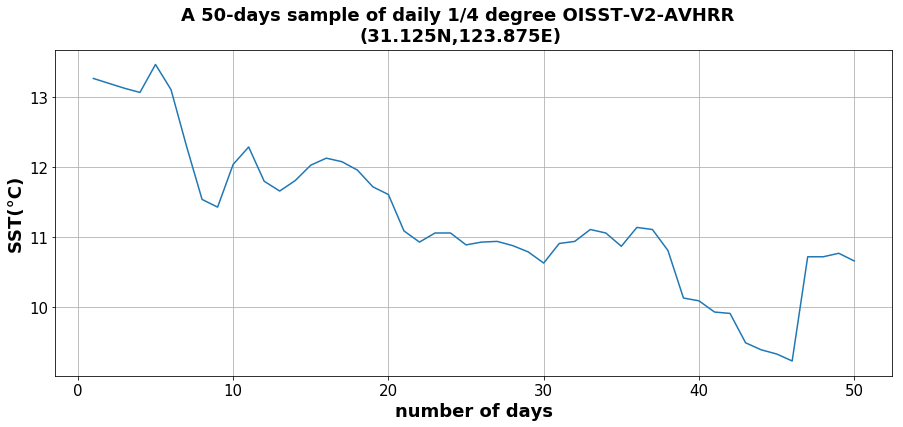

In [2287]:
# plot a sample of orignial time series (English Version)
n_sample_days=50
sample_days=[(i+1) for i in range(n_sample_days)]

fig,ax=pyplot.subplots(figsize=(15,6))
fig.suptitle('A 50-days sample of daily 1/4 degree OISST-V2-AVHRR \n'+location,fontsize=18,fontweight='bold')

ax.plot(sample_days,series.values[:n_sample_days])

# set x,y label
ax.set_xlabel(xlabel='number of days',
              fontsize=18,
              fontweight='bold')
ax.set_ylabel(ylabel='SST(\u00B0C)',
              fontsize=18,
              fontweight='bold')
# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
#legend=ax.legend(loc='upper left',fontsize=15,ncol=2)
#legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.825, 1.18))

# save fig
fig.savefig(resultsDir_en+'A 50-days sample of actual SST'+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()

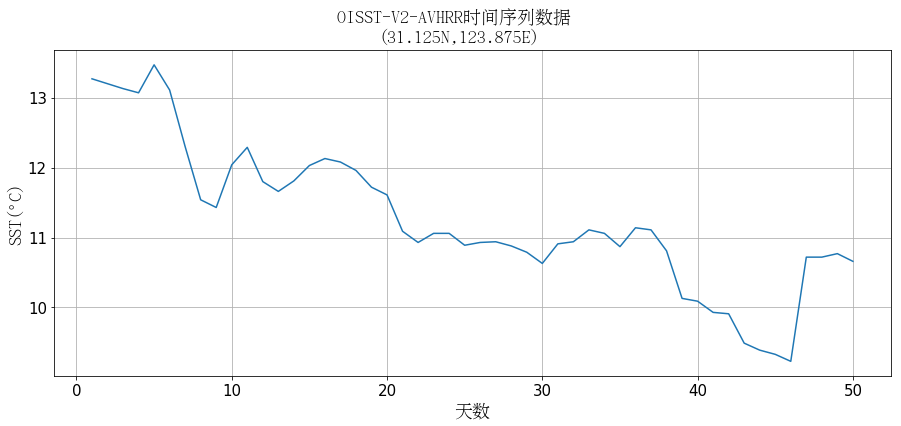

In [2288]:
# plot a sample of orignial time series (Chinese Version)
n_sample_days=50
sample_days=[(i+1) for i in range(n_sample_days)]

fig,ax=pyplot.subplots(figsize=(15,6))
fig.suptitle('OISST-V2-AVHRR时间序列数据 \n'+location,fontproperties=zhfont)

ax.plot(sample_days,series.values[:n_sample_days])

# set x,y label
ax.set_xlabel(xlabel='天数',fontproperties=zhfont)
ax.set_ylabel(ylabel='SST(\u00B0C)',fontproperties=zhfont)
# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
#legend=ax.legend(loc='upper left',fontsize=15,ncol=2)
#legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.825, 1.18))

# save fig
fig.savefig(resultsDir_cn+'A 50-days sample of actual SST'+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()

Coefficients: [[-3.28607144e-15]
 [ 3.70418813e-12]
 [-1.51479690e-09]
 [ 2.67133152e-07]
 [-2.14462367e-05]
 [ 1.82847040e-03]
 [-1.42638876e-01]
 [ 1.49689672e+01]]
fitted polynomial:
            7             6             5             4             3
-3.286e-15 x + 3.704e-12 x - 1.515e-09 x + 2.671e-07 x - 2.145e-05 x
             2
 + 0.001828 x - 0.1426 x + 14.97


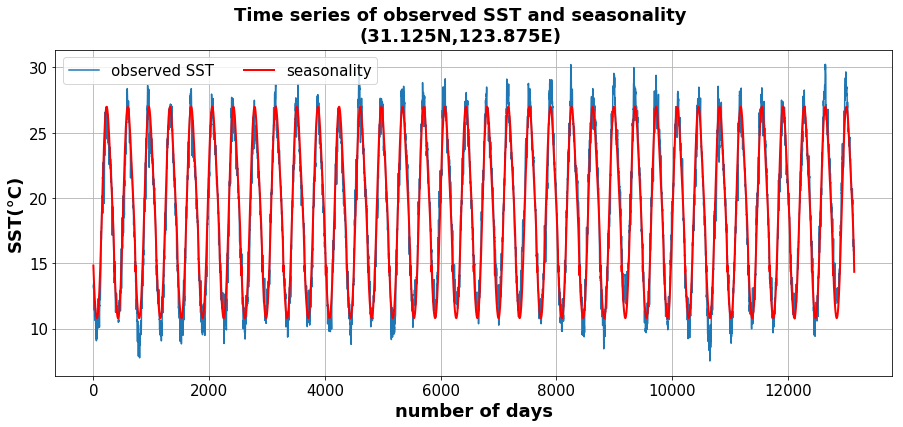

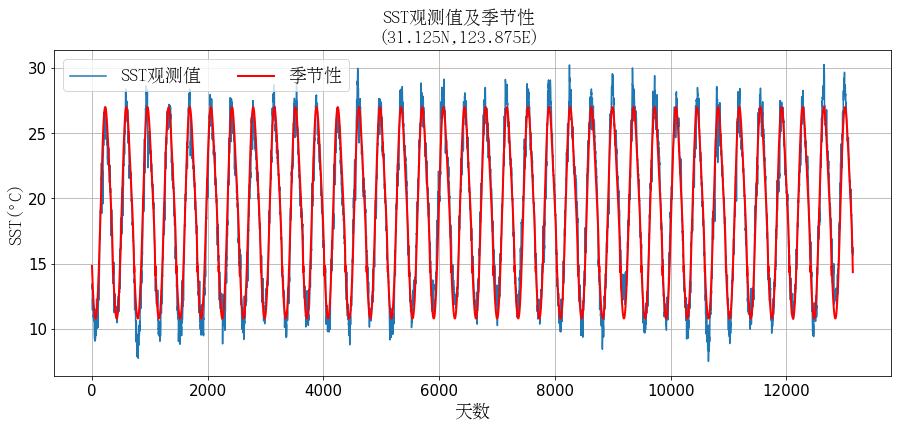

In [2289]:
# remove seasonality
# fit polynomial x^3*b1+x^2*b2+x*b3+b4
n_days=[(i+1) for i in range(len(series.values))]

X=[]
for date in dates.values:
    dateStr=np.array2string(date)[2:-2] # orginal dateStr is ['1982-01-01']
    #print(dateStr)
    targetDay=datetime.datetime.strptime(dateStr, '%Y-%m-%d')
    dayOfYear=targetDay-datetime.datetime(targetDay.year-1,12,31)
    X.append(dayOfYear.days)
#X = [i%365 for i in range(0, len(series))]
y = series.values

# if train model, set the degree manually
degree=np.nan
if boolean_train_lstm_model:
    degree = 7
else: # load degree from file
    seasonality_poly_file=resultsDir_en+'fitted polynomial for seasonality.csv'
    df_seasonality_poly_coef=pd.read_csv(seasonality_poly_file,usecols=[1],engine='python')
    degree=len(df_seasonality_poly_coef.values)-1
    
coef = np.polyfit(X, y, degree)
print('Coefficients: %s' % coef)
coef = np.squeeze(coef)
polyID=np.poly1d(coef)
print('fitted polynomial:')
print(polyID)

# save seasonality polynomial to csv
seasonality_poly={}
for i in range(degree+1):
    seasonality_poly['deg'+str(degree-i)]=coef[i]
df_seasonality_polynomial=pd.DataFrame.from_dict(seasonality_poly,orient='index')
df_seasonality_polynomial.to_csv(resultsDir_en+'fitted polynomial for seasonality.csv')
df_seasonality_polynomial.to_csv(resultsDir_cn+'fitted polynomial for seasonality.csv')

# create curve
trend_seasonality = np.polyval(coef, X)
trend_seasonality=trend_seasonality.reshape(-1,1)
trend_seasonality=pd.DataFrame(data=trend_seasonality)

######### plot orignial time series and fitted seasonality (English Version)########
fig,ax=pyplot.subplots(figsize=(15,6))
fig.suptitle('Time series of observed SST and seasonality\n'+location,fontsize=18,fontweight='bold')

ax.plot(n_days,series.values,label='observed SST')
ax.plot(trend_seasonality.values,label='seasonality',color='red', linewidth=2) 

# set x,y label
ax.set_xlabel(xlabel='number of days',
              fontsize=18,
              fontweight='bold')
ax.set_ylabel(ylabel='SST(\u00B0C)',
              fontsize=18,
              fontweight='bold')
# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
legend=ax.legend(loc='upper left',fontsize=15,ncol=2)
#legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.825, 1.18))

# save fig
fig.savefig(resultsDir_en+'Time series of observed SST and seasonality '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()


########## plot orignial time series and fitted seasonality(Chinese Version)########
fig,ax=pyplot.subplots(figsize=(15,6))
fig.suptitle('SST观测值及季节性\n'+location,fontproperties=zhfont)

ax.plot(n_days,series.values,label='SST观测值')
ax.plot(trend_seasonality.values,label='季节性',color='red', linewidth=2) 

# set x,y label
ax.set_xlabel(xlabel='天数',fontproperties=zhfont)
ax.set_ylabel(ylabel='SST(\u00B0C)',fontproperties=zhfont)
# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
legend=ax.legend(loc='upper left',ncol=2,prop=zhfont)
#legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.825, 1.18))

# save fig
fig.savefig(resultsDir_cn+'Time series of observed SST and seasonality '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()

In [2290]:
print(X[0])

1


In [2291]:
# save series after removal of seasonality to csv file
series_rm_seasonality=series.values-trend_seasonality.values
df_series_rm_seasonality=pd.DataFrame({'Datetime':[np.array2string(date)[2:-2] for date in dates.values],
                                       'SST_remove_seasonality':np.squeeze(series_rm_seasonality)
                                      })
df_series_rm_seasonality.to_csv(resultsDir_en+'SST_remove_seasonality.csv')
df_series_rm_seasonality.to_csv(resultsDir_cn+'SST_remove_seasonality.csv')
#print(df_series_rm_seasonality)

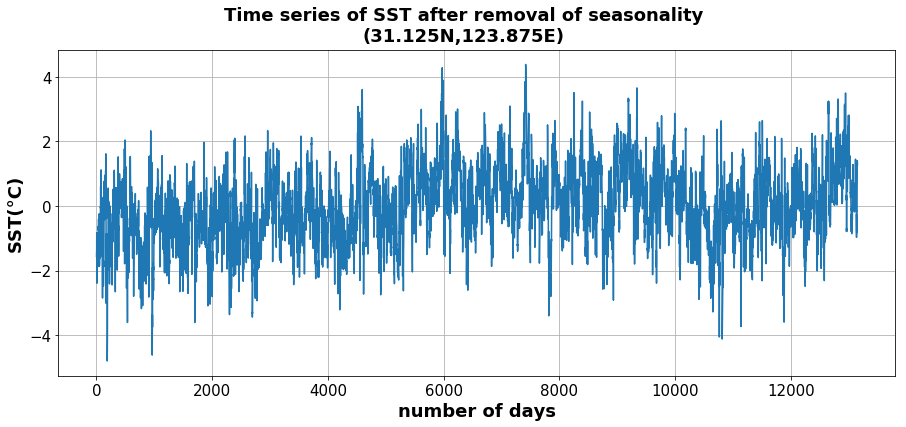

In [2292]:
# plot the time series after seasonality removal(English Version)
fig,ax=pyplot.subplots(figsize=(15,6))
fig.suptitle('Time series of SST after removal of seasonality\n'+location,fontsize=18,fontweight='bold')

ax.plot(n_days,series_rm_seasonality) 

# set x,y label
ax.set_xlabel(xlabel='number of days',
              fontsize=18,
              fontweight='bold')
ax.set_ylabel(ylabel='SST(\u00B0C)',
              fontsize=18,
              fontweight='bold')
# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
#legend=ax.legend(loc='upper left',fontsize=15)

# save fig
fig.savefig(resultsDir_en+'Time series of SST after removal of seasonality '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()

No handles with labels found to put in legend.


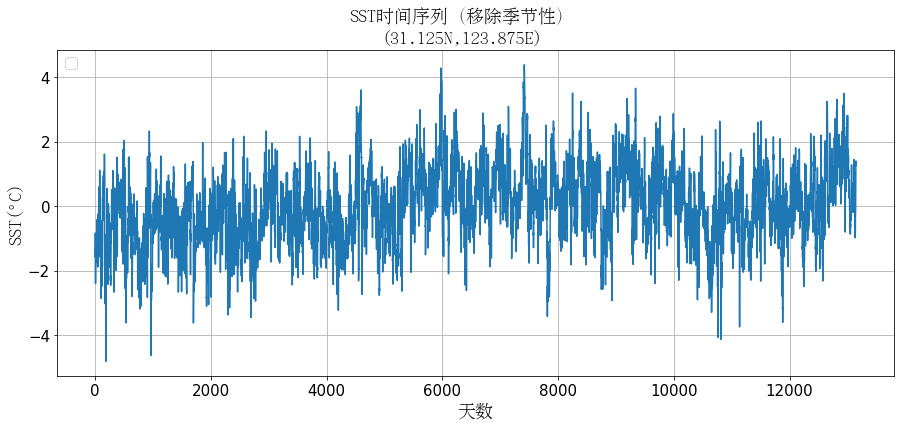

In [2293]:
# plot the time series after seasonality removal(Chinese Version)
fig,ax=pyplot.subplots(figsize=(15,6))
fig.suptitle('SST时间序列（移除季节性）\n'+location,fontproperties=zhfont)

ax.plot(n_days,series_rm_seasonality) 

# set x,y label
ax.set_xlabel(xlabel='天数',fontproperties=zhfont)
ax.set_ylabel(ylabel='SST(\u00B0C)',fontproperties=zhfont)
# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
legend=ax.legend(loc='upper left',fontsize=15)

# save fig
fig.savefig(resultsDir_cn+'Time series of SST after removal of seasonality '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()

In [2294]:
series=pd.DataFrame(data=series_rm_seasonality)

In [2295]:
# normalize features - 

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(series.values)
series = pd.DataFrame(scaled)

In [2296]:
window_size = 50

series_s = series.copy()
print(series.shape)
for i in range(window_size):
    series = pd.concat([series, series_s.shift(-(i+1))], axis = 1)
    
series.dropna(axis=0, inplace=True)

trend_seasonality_t=trend_seasonality.copy()
print(trend_seasonality_t.shape)
for i in range(window_size):
    trend_seasonality = pd.concat([trend_seasonality, trend_seasonality_t.shift(-(i+1))], axis = 1)
    
trend_seasonality.dropna(axis=0, inplace=True)

(13149, 1)
(13149, 1)


In [2297]:
series.head()

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0.353122,0.360444,0.367395,0.375075,0.432453,0.406810,0.331884,0.262082,0.262690,0.341333,...,0.374952,0.333954,0.327553,0.325285,0.318445,0.484367,0.487960,0.496768,0.487941,0.343980
1,0.360444,0.367395,0.375075,0.432453,0.406810,0.331884,0.262082,0.262690,0.341333,0.380520,...,0.333954,0.327553,0.325285,0.318445,0.484367,0.487960,0.496768,0.487941,0.343980,0.320551
2,0.367395,0.375075,0.432453,0.406810,0.331884,0.262082,0.262690,0.341333,0.380520,0.338916,...,0.327553,0.325285,0.318445,0.484367,0.487960,0.496768,0.487941,0.343980,0.320551,0.330617
3,0.375075,0.432453,0.406810,0.331884,0.262082,0.262690,0.341333,0.380520,0.338916,0.335116,...,0.325285,0.318445,0.484367,0.487960,0.496768,0.487941,0.343980,0.320551,0.330617,0.354592
4,0.432453,0.406810,0.331884,0.262082,0.262690,0.341333,0.380520,0.338916,0.335116,0.362599,...,0.318445,0.484367,0.487960,0.496768,0.487941,0.343980,0.320551,0.330617,0.354592,0.451224


In [2298]:
series.shape

(13099, 51)

In [2299]:
nrow = round(0.8*series.shape[0])

In [2300]:
train = series.iloc[:nrow, :]
test = series.iloc[nrow:,:]

In [2301]:
from sklearn.utils import shuffle
train = shuffle(train)

In [2302]:
train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

In [2303]:
train_X = train_X.values
train_y = train_y.values
test_X = test_X.values
test_y = test_y.values

In [2304]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(10479, 50)
(10479,)
(2620, 50)
(2620,)


In [2305]:
train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)

In [2306]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(10479, 50, 1)
(10479,)
(2620, 50, 1)
(2620,)


In [2307]:
model=object()

if boolean_train_lstm_model: # train a new model
    ###########################################  Define the LSTM model ########################################## 
    model = Sequential()
    # input_shape is the shape of inputs for the network, representing (time steps,features)
    # output_dim is the number of nurons in this LSTM layer.
    # if return_sequence is set to True, then each nueron will output a sequence the same size of input sequence
    model.add(LSTM(input_shape = (window_size,1), output_dim= 50, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(LSTM(256))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation("linear"))
    model.compile(loss="mse", optimizer="adam")
    tensorboard=keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
    early_stopping=EarlyStopping(monitor='val_loss',patience=1,mode='min')
    model.summary()
    plot_model(model,to_file='model.png')
    
    ########################################### Train LSTM Model ########################################## 
    batch_size_lstm=150
    epoch_lstm=20
    validation_split_lstm=0.16
    n_total_samples_lstm=train_X.shape[0]
    n_validate_samples_lstm=round(train_X.shape[0]*validation_split_lstm)
    n_train_samples_lstm=n_total_samples_lstm-n_validate_samples_lstm
    start_lstm_training = time.time()
    history=model.fit(train_X,train_y,
                      batch_size=batch_size_lstm,
                      nb_epoch=epoch_lstm,
                      validation_split=validation_split_lstm,
                      callbacks=[tensorboard])
    traing_time_lstm=time.time() - start_lstm_training
    print("> LSTM Model Compilation Time : ",traing_time_lstm)

    # save training configuration to csv file
    df_lstm_train_conf=pd.DataFrame.from_dict({'batch_size':batch_size_lstm,
                                    'epochs_set':epoch_lstm,
                                    'epoch_actual':len(history.history['loss']),
                                    'validation_split':validation_split_lstm,
                                    'total_samples':n_total_samples_lstm,
                                    'train_samples':n_train_samples_lstm,
                                    'validate_samples':n_validate_samples_lstm,
                                    'training_time':traing_time_lstm},orient='index')
    df_lstm_train_conf.to_csv(resultsDir_en+lstm_rm_seasonality_dir+'training configurations for LSTM model.csv')
    df_lstm_train_conf.to_csv(resultsDir_cn+lstm_rm_seasonality_dir+'training configurations for LSTM model.csv')

    # save model
    model.save(resultsDir_en+lstm_rm_seasonality_dir+'model.h5')
    model.save(resultsDir_cn+lstm_rm_seasonality_dir+'model.h5')
    
    ########################################## visualize training history #####################################
    ##########  plot LSTM training history (English Version)  ######### 
    fig,ax=pyplot.subplots(figsize=(6,6))
    fig.suptitle('LSTM model loss\n'+location,fontsize=18,fontweight='bold')

    # plot two series
    ax.plot(history.history['loss'],label='train',linewidth=2)
    ax.plot(history.history['val_loss'],label='validate',linewidth=2) 

    # set x,y label
    ax.set_xlabel(xlabel='epoch',
                  fontsize=18,
                  fontweight='bold')
    ax.set_ylabel(ylabel='loss',
                  fontsize=18,
                  fontweight='bold')
    # set tick labels
    pyplot.setp(ax.get_xticklabels(),fontsize=15)
    pyplot.setp(ax.get_yticklabels(),fontsize=15)
    # add grid
    #ax.grid()
    # add legend
    legend=ax.legend(loc='upper right',fontsize=15,ncol=1)
    #legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.75, 1.18))

    # save fig
    fig.savefig(resultsDir_en+lstm_rm_seasonality_dir+'LSTM model training and validation loss'+location+'.eps',
                dpi=300,
                orientation='portrait',
                format='eps',
                bbox_inches = 'tight')
    pyplot.show()
    
    ######### plot LSTM training history (Chinese version)  ######### 
    fig,ax=pyplot.subplots(figsize=(6,6))
    fig.suptitle('LSTM模型损失\n'+location,fontproperties=zhfont)

    # plot two series
    ax.plot(history.history['loss'],label='训练',linewidth=2)
    ax.plot(history.history['val_loss'],label='检验',linewidth=2) 

    # set x,y label
    ax.set_xlabel(xlabel='迭代次数',fontproperties=zhfont)
    ax.set_ylabel(ylabel='模型损失',fontproperties=zhfont)
    # set tick labels
    pyplot.setp(ax.get_xticklabels(),fontsize=15)
    pyplot.setp(ax.get_yticklabels(),fontsize=15)
    # add grid
    #ax.grid()
    # add legend
    legend=ax.legend(loc='upper right',ncol=1,prop=zhfont)
    #legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.75, 1.18))

    # save fig
    fig.savefig(resultsDir_cn+lstm_rm_seasonality_dir+'LSTM model training and validation loss'+location+'.eps',
                dpi=300,
                orientation='portrait',
                format='eps',
                bbox_inches = 'tight')
    pyplot.show()
    
else: # load trained model
    model=load_model(resultsDir_en+lstm_rm_seasonality_dir+'model.h5')

In [2308]:
# grid search hyperparameters for the model
#model_=KerasRegressor(build_fn=model,verbose=0)

#batch_size_lstm=[10,20,30,40,50,60,70,80,90,100]
#epochs_lstm=[10,20,30]
#param_grid_lstm=dict(batch_size=batch_size_lstm,epochs=epochs_lstm)
#grid_search_lstm=GridSearchCV(estimator=model_,param_grid=param_grid_lstm)
#grid_result_lstm=grid_search_lstm.fit(train_X,train_y)
# summarize the results
#print('Best:%f using %s'%(grid_result_lstm.best_score_,grid_result_lstm.best_params_))
#means=grid_result_lstm.cv_results_['mean_test_score']
#stds=grid_result_lstm.cv_results_['std_test_score']
#params=grid_result_lstm.cv_results_['params']
#for mean, stdev, param in zip(means,stds,params):
    #print('%f (%f) with %r'%(mean,stdev,param))

In [2309]:
# SVR regression model
start_svr_training = time.time()
svr_rbf=GridSearchCV(SVR(kernel='rbf',gamma=0.1),cv=5,
                    param_grid={'C':[1e0,1e1,1e2,1e3],
                               'gamma':np.logspace(-2,2,5)},
                    n_jobs=-1) # use all cores
svr_rbf_model=svr_rbf.fit(train_X.reshape(train_X.shape[0],train_X.shape[1]),train_y)
best_params=svr_rbf.best_params_
time_cost_svr_grid_search_train=time.time() - start_svr_training
print('> best parameters for SVR:%s \n'%best_params)
print("> SVR complexity and bandwidth selected and model fitted in %.3f seconds"%time_cost_svr_grid_search_train)

# save best parameters for SVR to csv file
df_svr_grid_search_train=pd.DataFrame.from_dict(best_params,orient='index')
df_svr_grid_search_train.loc['time_cost']=time_cost_svr_grid_search_train
df_svr_grid_search_train.to_csv(resultsDir_en+svr_rm_seasonality_dir+'Results of Grid search for best parameters of SVR.csv')
df_svr_grid_search_train.to_csv(resultsDir_cn+svr_rm_seasonality_dir+'Results of Grid search for best parameters of SVR.csv')

> best parameters for SVR:{'gamma': 0.01, 'C': 10.0} 

> SVR complexity and bandwidth selected and model fitted in 45.365 seconds


In [2310]:
# Doing a prediction on all the test data at once
# lstm prediction
preds_1day_lstm = model.predict(test_X)
# svr  prediction
preds_1day_svr=svr_rbf_model.predict(test_X.reshape(test_X.shape[0],test_X.shape[1]))

In [2311]:
# inverse predictions
# (1) inverse to original scale
# (2) add seasonality

# lstm prediction
preds_1day_lstm = scaler.inverse_transform(preds_1day_lstm)
#print(preds_1day_lstm)
#print(preds_1day_lstm[:,0])
#print(trend_seasonality.shape)
#print(preds_1day_lstm.shape)
preds_1day_lstm=np.add(preds_1day_lstm[:,0],trend_seasonality.values[nrow:,-1])
preds_1day_lstm=preds_1day_lstm.reshape(-1,1)
#print(preds_1day_lstm.shape)
#print(test_y.shape)

# svr prediction
preds_1day_svr = scaler.inverse_transform(preds_1day_svr.reshape(-1,1))
#print(preds_1day_svr)
#print(preds_1day_lstm[:,0])
#print(trend_seasonality.shape)
#print(preds_1day_lstm.shape)
preds_1day_svr=np.add(preds_1day_svr[:,0],trend_seasonality.values[nrow:,-1])
preds_1day_svr=preds_1day_svr.reshape(-1,1)
#print(preds_1day_lstm.shape)
#print(test_y.shape)

In [2312]:
actuals = scaler.inverse_transform(test_y.reshape(-1,1)) #xcj added reshape part
actuals=np.add(actuals[:,0],trend_seasonality.values[nrow:,-1])
actuals=actuals.reshape(-1,1)

In [2313]:
# calculate statistics
# LSTM 
print('statistics of LSTM prediction for 1 day ahead:')
RMSE_preds_1day_lstm=math.sqrt(mean_squared_error(actuals,preds_1day_lstm))
print('    RMSE: %f'%(RMSE_preds_1day_lstm))
r_preds_1day_lstm,pvalue_preds_1day_lstm=pearsonr(actuals,preds_1day_lstm)
print('    Pearson\'s Correlation coefficient: %f, p-value: %f'%(r_preds_1day_lstm,pvalue_preds_1day_lstm))

# SVR
print('statistics of SVR prediction for 1 day ahead:')
RMSE_preds_1day_svr=math.sqrt(mean_squared_error(actuals,preds_1day_svr))
print('    RMSE: %f'%(RMSE_preds_1day_svr))
r_preds_1day_svr,pvalue_preds_1day_svr=pearsonr(actuals,preds_1day_svr)
print('    Pearson\'s Correlation coefficient: %f, p-value: %f'%(r_preds_1day_svr,pvalue_preds_1day_svr))

statistics of LSTM prediction for 1 day ahead:
    RMSE: 0.403498
    Pearson's Correlation coefficient: 0.997525, p-value: 0.000000
statistics of SVR prediction for 1 day ahead:
    RMSE: 0.411761
    Pearson's Correlation coefficient: 0.997451, p-value: 0.000000


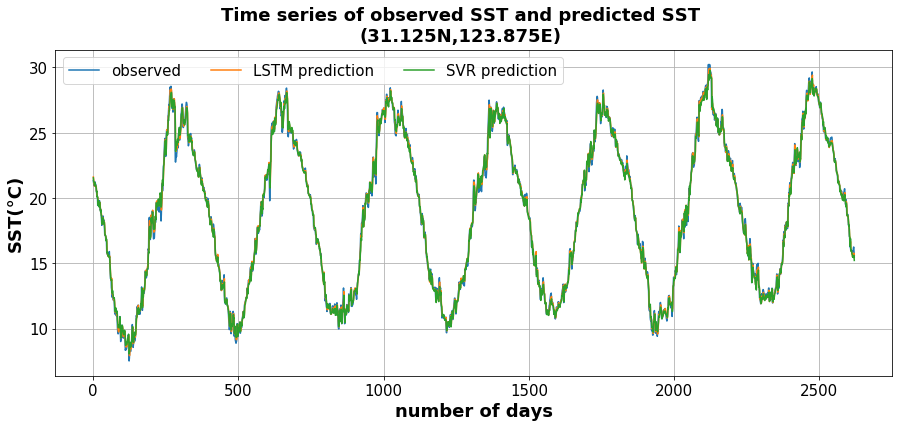

In [2314]:
# plot actual SST and predicted SST for 1 day ahead (English version)
n_days=[(i+1) for i in range(len(actuals))]

fig,ax=pyplot.subplots(figsize=(15,6))
fig.suptitle('Time series of observed SST and predicted SST\n'+location,fontsize=18,fontweight='bold')

# plot two series
ax.plot(n_days,actuals,label='observed')
ax.plot(n_days,preds_1day_lstm,label='LSTM prediction') 
ax.plot(n_days,preds_1day_svr,label='SVR prediction')

# set x,y label
ax.set_xlabel(xlabel='number of days',
              fontsize=18,
              fontweight='bold')
ax.set_ylabel(ylabel='SST(\u00B0C)',
              fontsize=18,
              fontweight='bold')
# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
legend=ax.legend(loc='upper left',fontsize=15,ncol=3)
#legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.75, 1.18))

# save fig
fig.savefig(resultsDir_en+'Time series of actual SST and predicted SST for 1 day ahead '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()

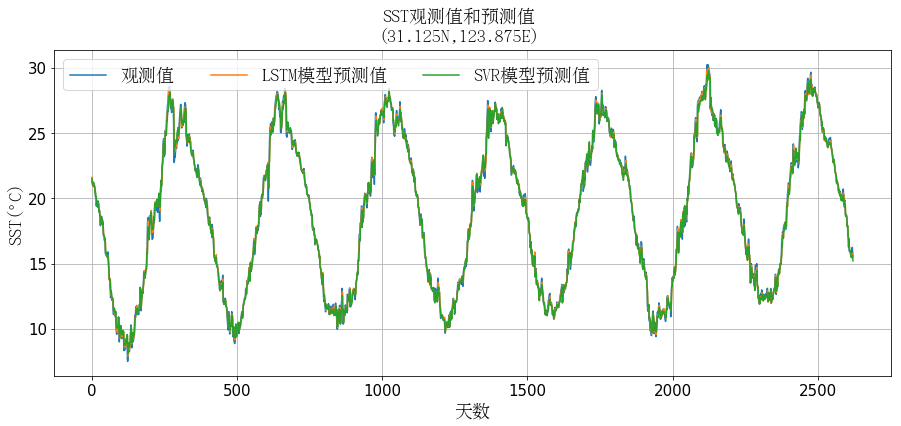

In [2315]:
# plot actual SST and predicted SST for 1 day ahead (Chinese Version)
n_days=[(i+1) for i in range(len(actuals))]

fig,ax=pyplot.subplots(figsize=(15,6))
fig.suptitle('SST观测值和预测值\n'+location,fontproperties=zhfont)

# plot two series
ax.plot(n_days,actuals,label='观测值')
ax.plot(n_days,preds_1day_lstm,label='LSTM模型预测值') 
ax.plot(n_days,preds_1day_svr,label='SVR模型预测值')

# set x,y label
ax.set_xlabel(xlabel='天数',fontproperties=zhfont)
ax.set_ylabel(ylabel='SST(\u00B0C)',fontproperties=zhfont)
# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
legend=ax.legend(loc='upper left',ncol=3,prop=zhfont)
#legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.75, 1.18))

# save fig
fig.savefig(resultsDir_cn+'Time series of actual SST and predicted SST for 1 day ahead '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()

In [2316]:
#pyplot.figure(figsize=(15,6))
#pyplot.plot(preds_1day)
#pyplot.show()

In [2317]:
def create_colnames(n_future_preds):
    return ['T+'+str(i+1) for i in range(n_future_preds)]
print(create_colnames(7))

['T+1', 'T+2', 'T+3', 'T+4', 'T+5', 'T+6', 'T+7']


In [2318]:
# using moving window to make N days ahead predictions on specified test sample (LSTM)
# return a list storing N days ahead (1~N) predictions for specified test sample
def moving_test_window_preds_lstm(testX,i_test_sample,n_future_preds):

    ''' testX         - test samples
        i_test_sample  - index of test sample used  to make predictions
        n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window. It's in colume form.
    moving_test_window = [testX[i_test_sample,:].tolist()]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    #shape_moving_test_window=moving_test_window.shape    # added by xcj
    
    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
        #moving_test_window=scaler.fit_transform(moving_test_window[0,:]) # added by xcj
        #moving_test_window=moving_test_window.reshape(shape_moving_test_window) # added by xcj
        
    preds_moving=np.array(preds_moving) # xcj added
    # print(preds_moving.shape)
    preds_moving = scaler.inverse_transform(preds_moving.reshape(preds_moving.shape[0],1)) # xcj added reshape part
    
    return preds_moving

In [2319]:
# using moving window to make N days ahead predictions on all test samples (LSTM)
# return a pandas dataframe object with each row storing N days ahead (1~N) predictions for a testing input
def moving_test_window_preds_lstm_all(testX, n_future_preds):

    ''' testX         - test samples
        n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving=[]
    moving_test_window=testX
    print(moving_test_window.shape)
    moving_test_window=np.array(moving_test_window)
    print(moving_test_window.shape)
    for i in range(n_future_preds):
        preds_one_step=model.predict(moving_test_window)
        preds_moving.append(preds_one_step)
        preds_one_step=preds_one_step.reshape(-1,1,1)
        moving_test_window=np.concatenate((moving_test_window[:,1:,:],preds_one_step),axis=1)
    
    preds_moving=np.array(preds_moving)
    print(preds_moving.shape)
    preds_moving=scaler.inverse_transform(preds_moving.reshape(preds_moving.shape[0],preds_moving.shape[1]))
    print(preds_moving.shape)
    
    
    return pd.DataFrame(preds_moving.T,columns=create_colnames(n_future_preds)) # Use this to store the predictions on all test sampels.

#print(moving_test_window_preds_lstm_all(test_X,3))

In [2320]:
# using moving window to make N days ahead predictions on specified test sample (SVR)
# return a list storing N days ahead (1~N) predictions for specified test sample
def moving_test_window_preds_svr(testX,i_test_sample,n_future_preds):

    ''' testX         - test samples
        i_test_sample  - index of test sample used  to make predictions
        n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window. It's in colume form.
    moving_test_window = [testX.reshape(testX.shape[0],testX.shape[1])[i_test_sample,:].tolist()]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    #shape_moving_test_window=moving_test_window.shape    # added by xcj
    
    for i in range(n_future_preds):
        preds_one_step = svr_rbf_model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_one_step=preds_one_step.reshape(-1,1)
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        #preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
        #moving_test_window=scaler.fit_transform(moving_test_window[0,:]) # added by xcj
        #moving_test_window=moving_test_window.reshape(shape_moving_test_window) # added by xcj
        
    preds_moving=np.array(preds_moving) # xcj added
    # print(preds_moving.shape)
    preds_moving = scaler.inverse_transform(preds_moving.reshape(preds_moving.shape[0],1)) # xcj added reshape part
    
    return preds_moving

In [2321]:
# using moving window to make N days ahead predictions on all test samples (SVR)
# return a pandas dataframe object with each row storing N days ahead (1~N) predictions for a testing input
def moving_test_window_preds_svr_all(testX, n_future_preds):

    ''' testX         - test samples
        n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving=[]
    moving_test_window=testX.reshape(testX.shape[0],testX.shape[1])
    print(moving_test_window.shape)
    moving_test_window=np.array(moving_test_window)
    print(moving_test_window.shape)
    for i in range(n_future_preds):
        preds_one_step=svr_rbf_model.predict(moving_test_window)
        preds_moving.append(preds_one_step)
        preds_one_step=preds_one_step.reshape(-1,1)
        moving_test_window=np.concatenate((moving_test_window[:,1:],preds_one_step),axis=1)
    
    preds_moving=np.array(preds_moving)
    preds_moving=scaler.inverse_transform(preds_moving.reshape(preds_moving.shape[0],preds_moving.shape[1]))
    return pd.DataFrame(preds_moving.T,columns=create_colnames(n_future_preds))
    #df_predictions=pd.DataFrame(columns=create_colnames(n_future_preds)) # Use this to store the predictions on all test sampels.
    #n_test_samples=testX.shape[0]
    #for i in range(n_test_samples):
        #preds_moving=moving_test_window_preds_svr(testX,i,n_future_preds)
        #df_predictions.loc[i]=preds_moving.reshape(-1,)
    
    #return df_predictions

#print(moving_test_window_preds_svr_all(test_X,1))
#print(preds_1day_svr)

In [2322]:
# making predictions using moving window for the first test sample
# number of days to predict
n_future_preds=56

# LSTM prediction
preds_moving_lstm = moving_test_window_preds_lstm(test_X,0,n_future_preds)
preds_moving_lstm=np.add(preds_moving_lstm[:,0],trend_seasonality.values[nrow:nrow+n_future_preds,-1])
preds_moving_lstm=preds_moving_lstm.reshape(-1,1)

# SVR prediction
preds_moving_svr = moving_test_window_preds_svr(test_X,0,n_future_preds)
preds_moving_svr=np.add(preds_moving_svr[:,0],trend_seasonality.values[nrow:nrow+n_future_preds,-1])
preds_moving_svr=preds_moving_svr.reshape(-1,1)

In [2323]:
#print(preds_moving)

In [2324]:
#print(trend_seasonality.values[nrow:nrow+n_future_preds,-1])

In [2325]:
# calculate statistics
actuals_sub=actuals[0:n_future_preds,0]
preds_moving_lstm=preds_moving_lstm[:,0]
preds_moving_svr=preds_moving_svr[:,0]

# LSTM 
print('statistics for LSTM prediction using moving window:')
RMSE_preds_moving_lstm=math.sqrt(mean_squared_error(actuals_sub,preds_moving_lstm))
print('    RMSE: %f'%(RMSE_preds_moving_lstm))
r_preds_moving_lstm,pvalue_preds_moving_lstm=pearsonr(actuals_sub,preds_moving_lstm)
print('    Pearson\'s Correlation coefficient: %f, p-value: %f'%(r_preds_moving_lstm,pvalue_preds_moving_lstm))

# SVR
print('statistics for SVR prediction using moving window:')
RMSE_preds_moving_svr=math.sqrt(mean_squared_error(actuals_sub,preds_moving_svr))
print('    RMSE: %f'%(RMSE_preds_moving_svr))
r_preds_moving_svr,pvalue_preds_moving_svr=pearsonr(actuals_sub,preds_moving_svr)
print('    Pearson\'s Correlation coefficient: %f, p-value: %f'%(r_preds_moving_svr,pvalue_preds_moving_svr))

statistics for LSTM prediction using moving window:
    RMSE: 0.653373
    Pearson's Correlation coefficient: 0.983129, p-value: 0.000000
statistics for SVR prediction using moving window:
    RMSE: 0.422300
    Pearson's Correlation coefficient: 0.984424, p-value: 0.000000


In [2326]:
# store statistics
df_stat_preds_moving_one_test_sample=pd.DataFrame({'RMSE':[RMSE_preds_moving_lstm,RMSE_preds_moving_svr],
                'R':[r_preds_moving_lstm,r_preds_moving_svr],
                'p-value':[pvalue_preds_moving_lstm,pvalue_preds_moving_svr]},index=['LSTM','SVR'])
df_stat_preds_moving_one_test_sample.to_csv(resultsDir_en+'statistics of predictions using one test sample based on moving window.csv')
df_stat_preds_moving_one_test_sample.to_csv(resultsDir_cn+'statistics of predictions using one test sample based on moving window.csv')

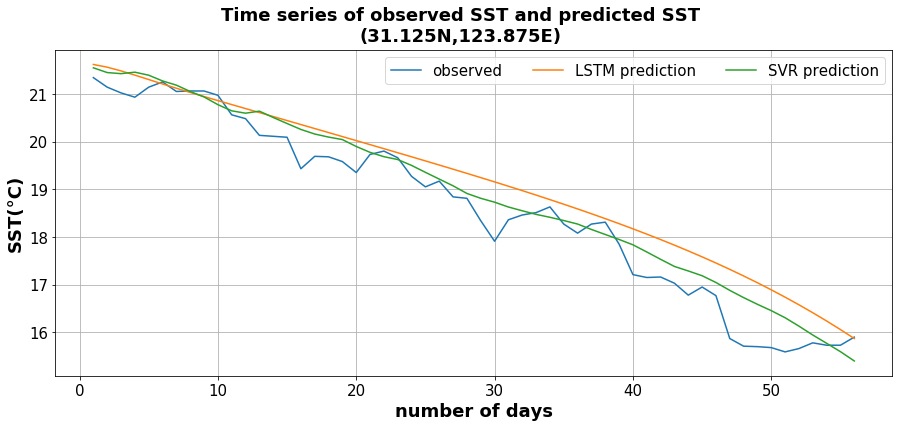

In [2327]:
# plot prediction results using one test sample based on moving window (English version)
fig,ax=pyplot.subplots(figsize=(15,6))
n_preds_horizons=[(i+1) for i in range(len(actuals_sub))]

fig.suptitle('Time series of observed SST and predicted SST\n'+location,fontsize=18,fontweight='bold')
#pyplot.figure(figsize=(20,6))
ax.plot(n_preds_horizons,actuals_sub,label='observed')
ax.plot(n_preds_horizons,preds_moving_lstm,label='LSTM prediction') 
ax.plot(n_preds_horizons,preds_moving_svr,label='SVR prediction') 

# set x,y label
ax.set_xlabel(xlabel='number of days',
              fontsize=18,
              fontweight='bold')
ax.set_ylabel(ylabel='SST(\u00B0C)',
              fontsize=18,
              fontweight='bold')
# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
legend=ax.legend(loc='upper right',fontsize=15,ncol=3)
#legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.825, 1.18))

# save fig
fig.savefig(resultsDir_en+'Time series of observed SST and predicted SST using moving window '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()

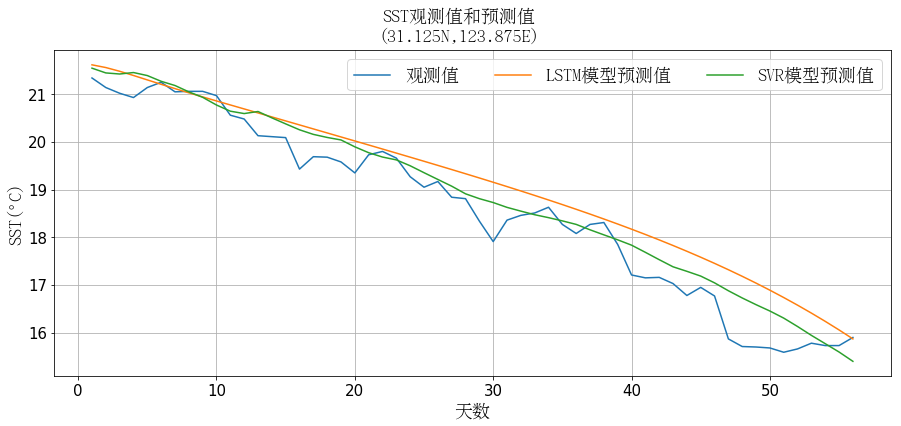

In [2328]:
# plot prediction results using one test sample based on moving window (Chinese version)
fig,ax=pyplot.subplots(figsize=(15,6))
n_preds_horizons=[(i+1) for i in range(len(actuals_sub))]

fig.suptitle('SST观测值和预测值\n'+location,fontproperties=zhfont)
#pyplot.figure(figsize=(20,6))
ax.plot(n_preds_horizons,actuals_sub,label='观测值')
ax.plot(n_preds_horizons,preds_moving_lstm,label='LSTM模型预测值') 
ax.plot(n_preds_horizons,preds_moving_svr,label='SVR模型预测值') 

# set x,y label
ax.set_xlabel(xlabel='天数',fontproperties=zhfont)
ax.set_ylabel(ylabel='SST(\u00B0C)',fontproperties=zhfont)
# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
legend=ax.legend(loc='upper right',ncol=3,prop=zhfont)
#legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.825, 1.18))

# save fig
fig.savefig(resultsDir_cn+'Time series of observed SST and predicted SST using moving window '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()

In [2329]:
# make linear regressions between acutals and predicts (LSTM)
regr=linear_model.LinearRegression()
regr.fit(preds_moving_lstm.reshape(-1,1),actuals_sub.reshape(-1,1))
fit_value=regr.predict(preds_moving_lstm.reshape(-1,1))

intercept=regr.intercept_
coef=regr.coef_[0,0]
rmse=math.sqrt(mean_squared_error(actuals_sub,fit_value))
r2=r2_score(actuals_sub,fit_value)

print('Coefficients:%.2f'%coef)
print('Intercept:%.2f'%intercept)
print('RMSE: %.3f'%rmse)
print('Variance score (R-square):%.3f'%r2)

Coefficients:1.12
Intercept:-2.89
RMSE: 0.335
Variance score (R-square):0.967


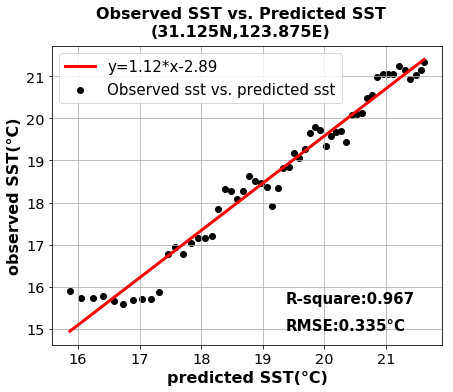

In [2330]:
# plot the regression (English version)
fig,ax=pyplot.subplots(figsize=(7,5.5))
fig.suptitle('Observed SST vs. Predicted SST\n'+location,fontsize=16,fontweight='bold')
ax.scatter(preds_moving_lstm,actuals_sub,color='black',label='Observed sst vs. predicted sst')
if intercept>0:
    ax.plot(preds_moving_lstm,fit_value,color='red',linewidth=3,label='y=%.2f*x+%.2f'%(coef,intercept))
elif intercept<0:
    ax.plot(preds_moving_lstm,fit_value,color='red',linewidth=3,label='y=%.2f*x-%.2f'%(coef,abs(intercept)))
else:
    ax.plot(preds_moving_lstm,fit_value,color='red',linewidth=3,label='y=%.2f*x'%(coef))

# set x,y label
ax.set_xlabel(xlabel='predicted SST(\u00B0C)',
              fontsize=16,
              fontweight='bold')
ax.set_ylabel(ylabel='observed SST(\u00B0C)',
              fontsize=16,
              fontweight='bold')

# add text
ax.text(0.6,0.14,
        'R-square:%.3f'%(r2),
        fontsize=15,
        fontweight='bold',
        transform=ax.transAxes)
ax.text(0.6,0.05,
        'RMSE:%.3f\u00B0C'%(rmse),
        fontsize=15,
        fontweight='bold',
        transform=ax.transAxes)
pyplot.setp(ax.get_xticklabels(),fontsize=14.5)
pyplot.setp(ax.get_yticklabels(),fontsize=14.5)

# add grid
ax.grid()

# add legend
#legend=ax.legend(loc='upper left',fontsize=15,prop={'weight':'bold'})
legend=ax.legend(loc='upper left',fontsize=15)

# show plot
pyplot.show()

# save fig
fig.savefig(resultsDir_en+lstm_rm_seasonality_dir+'regression of observed SST and LSTM predicted SST using moving window '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')

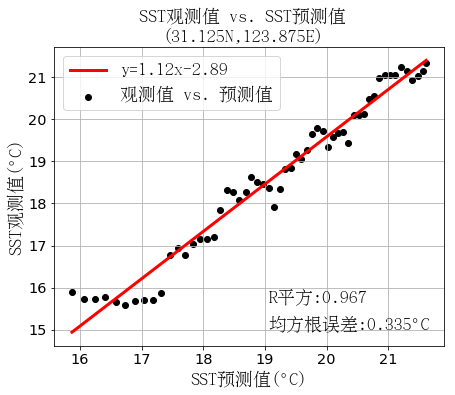

In [2331]:
# plot the regression (chinese version)
fig,ax=pyplot.subplots(figsize=(7,5.5))
fig.suptitle('SST观测值 vs. SST预测值\n'+location,fontproperties=zhfont)
ax.scatter(preds_moving_lstm,actuals_sub,color='black',label='观测值 vs. 预测值')
if intercept>0:
    ax.plot(preds_moving_lstm,fit_value,color='red',linewidth=3,label='y=%.2fx+%.2f'%(coef,intercept))
elif intercept<0:
    ax.plot(preds_moving_lstm,fit_value,color='red',linewidth=3,label='y=%.2fx-%.2f'%(coef,abs(intercept)))
else:
    ax.plot(preds_moving_lstm,fit_value,color='red',linewidth=3,label='y=%.2fx'%(coef))

# set x,y label
ax.set_xlabel(xlabel='SST预测值(\u00B0C)',fontproperties=zhfont)
ax.set_ylabel(ylabel='SST观测值(\u00B0C)',fontproperties=zhfont)

# add text
ax.text(0.55,0.14,
        'R平方:%.3f'%(r2),
        fontproperties=zhfont,
        transform=ax.transAxes)
ax.text(0.55,0.05,
        '均方根误差:%.3f\u00B0C'%(rmse),
        fontproperties=zhfont,
        transform=ax.transAxes)
pyplot.setp(ax.get_xticklabels(),fontsize=14.5)
pyplot.setp(ax.get_yticklabels(),fontsize=14.5)

# add grid
ax.grid()

# add legend
#legend=ax.legend(loc='upper left',fontsize=15,prop={'weight':'bold'})
legend=ax.legend(loc='upper left',prop=zhfont)

# show plot
pyplot.show()

# save fig
fig.savefig(resultsDir_cn+lstm_rm_seasonality_dir+'regression of observed SST and LSTM predicted SST using moving window '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')

In [2332]:
# make linear regressions between acutals and predicts (SVR)
regr=linear_model.LinearRegression()
regr.fit(preds_moving_svr.reshape(-1,1),actuals_sub.reshape(-1,1))
fit_value=regr.predict(preds_moving_svr.reshape(-1,1))

intercept=regr.intercept_
coef=regr.coef_[0,0]
rmse=math.sqrt(mean_squared_error(actuals_sub,fit_value))
r2=r2_score(actuals_sub,fit_value)

print('Coefficients:%.2f'%coef)
print('Intercept:%.2f'%intercept)
print('RMSE: %.3f'%rmse)
print('Variance score (R-square):%.3f'%r2)

Coefficients:1.02
Intercept:-0.68
RMSE: 0.322
Variance score (R-square):0.969


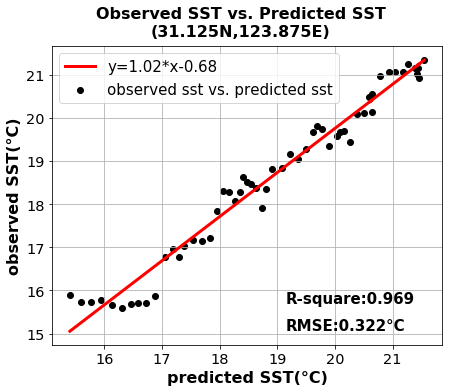

In [2333]:
# plot the regression (English Version)
fig,ax=pyplot.subplots(figsize=(7,5.5))
fig.suptitle('Observed SST vs. Predicted SST\n'+location,fontsize=16,fontweight='bold')
ax.scatter(preds_moving_svr,actuals_sub,color='black',label='observed sst vs. predicted sst')
if intercept>0:
    ax.plot(preds_moving_svr,fit_value,color='red',linewidth=3,label='y=%.2f*x+%.2f'%(coef,intercept))
elif intercept<0:
    ax.plot(preds_moving_svr,fit_value,color='red',linewidth=3,label='y=%.2f*x-%.2f'%(coef,abs(intercept)))
else:
    ax.plot(preds_moving_svr,fit_value,color='red',linewidth=3,label='y=%.2f*x'%(coef))

# set x,y label
ax.set_xlabel(xlabel='predicted SST(\u00B0C)',
              fontsize=16,
              fontweight='bold')
ax.set_ylabel(ylabel='observed SST(\u00B0C)',
              fontsize=16,
              fontweight='bold')

# add text
ax.text(0.6,0.14,
        'R-square:%.3f'%(r2),
        fontsize=15,
        fontweight='bold',
        transform=ax.transAxes)
ax.text(0.6,0.05,
        'RMSE:%.3f\u00B0C'%(rmse),
        fontsize=15,
        fontweight='bold',
        transform=ax.transAxes)
pyplot.setp(ax.get_xticklabels(),fontsize=14.5)
pyplot.setp(ax.get_yticklabels(),fontsize=14.5)

# add grid
ax.grid()

# add legend
#legend=ax.legend(loc='upper left',fontsize=15,prop={'weight':'bold'})
legend=ax.legend(loc='upper left',fontsize=15)

# show plot
pyplot.show()

# save fig
fig.savefig(resultsDir_en+svr_rm_seasonality_dir+'/regression of observed SST and SVR predicted SST using moving window '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')

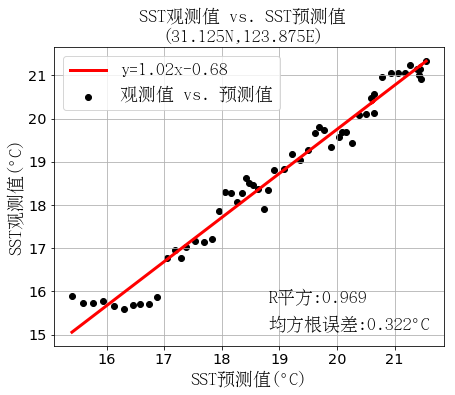

In [2334]:
# plot the regression (Chinese Version)
fig,ax=pyplot.subplots(figsize=(7,5.5))
fig.suptitle('SST观测值 vs. SST预测值\n'+location,fontproperties=zhfont)
ax.scatter(preds_moving_svr,actuals_sub,color='black',label='观测值 vs. 预测值')
if intercept>0:
    ax.plot(preds_moving_svr,fit_value,color='red',linewidth=3,label='y=%.2fx+%.2f'%(coef,intercept))
elif intercept<0:
    ax.plot(preds_moving_svr,fit_value,color='red',linewidth=3,label='y=%.2fx-%.2f'%(coef,abs(intercept)))
else:
    ax.plot(preds_moving_svr,fit_value,color='red',linewidth=3,label='y=%.2fx'%(coef))

# set x,y label
ax.set_xlabel(xlabel='SST预测值(\u00B0C)',fontproperties=zhfont)
ax.set_ylabel(ylabel='SST观测值(\u00B0C)',fontproperties=zhfont)

# add text
ax.text(0.55,0.14,
        'R平方:%.3f'%(r2),
        fontproperties=zhfont,
        transform=ax.transAxes)
ax.text(0.55,0.05,
        '均方根误差:%.3f\u00B0C'%(rmse),
        fontproperties=zhfont,
        transform=ax.transAxes)
pyplot.setp(ax.get_xticklabels(),fontsize=14.5)
pyplot.setp(ax.get_yticklabels(),fontsize=14.5)

# add grid
ax.grid()

# add legend
#legend=ax.legend(loc='upper left',fontsize=15,prop={'weight':'bold'})
legend=ax.legend(loc='upper left',prop=zhfont)

# show plot
pyplot.show()

# save fig
fig.savefig(resultsDir_cn+svr_rm_seasonality_dir+'/regression of observed SST and SVR predicted SST using moving window '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')

In [2335]:
# making N days ahead predictions on all test samples
# LSTM prediction
preds_moving_lstm_all_noseasonality = moving_test_window_preds_lstm_all(test_X,n_future_preds) # a dataframe
# SVR prediction
preds_moving_svr_all_noseasonality=moving_test_window_preds_svr_all(test_X,n_future_preds) # a dataframe

(2620, 50, 1)
(2620, 50, 1)
(56, 2620, 1)
(56, 2620)
(2620, 50)
(2620, 50)


In [2336]:
preds_moving_lstm_all=preds_moving_lstm_all_noseasonality.copy()
preds_moving_svr_all=preds_moving_svr_all_noseasonality.copy()

In [2337]:
# add back seasonality
n_test=preds_moving_lstm_all.shape[0]
for i in range(n_test): 
    if i<=n_test-n_future_preds:
        # LSTM
        i_preds_moving_lstm=preds_moving_lstm_all.loc[i]
        preds_moving_lstm_all.loc[i]=np.add(i_preds_moving_lstm,
                                    trend_seasonality.values[(nrow+i):(nrow+i+n_future_preds),-1])

        # SVR
        i_preds_moving_svr=preds_moving_svr_all.loc[i]
        preds_moving_svr_all.loc[i]=np.add(i_preds_moving_svr,
                                    trend_seasonality.values[(nrow+i):(nrow+i+n_future_preds),-1])
    else:
        # LSTM
        preds_moving_lstm_all.iloc[i,:n_test-i]=np.add(preds_moving_lstm_all.iloc[i,:n_test-i],
                                                       trend_seasonality.values[(nrow+i):(nrow+n_test),-1])
        preds_moving_lstm_all.iloc[i,n_test-i:]=np.nan
            
        # SVR
        preds_moving_svr_all.iloc[i,:n_test-i]=np.add(preds_moving_svr_all.iloc[i,:n_test-i],
                                                      trend_seasonality.values[(nrow+i):(nrow+n_test),-1])
        preds_moving_svr_all.iloc[i,n_test-i:]=np.nan   

In [2338]:
# save summary statistics of predicted SST using moving window to csv file
description_preds_moving_lstm_all_noseasonality=preds_moving_lstm_all_noseasonality.describe()
description_preds_moving_lstm_all_noseasonality.to_csv(resultsDir_en+'description_preds_moving_lstm_all_noseasonality.csv')
description_preds_moving_lstm_all_noseasonality.to_csv(resultsDir_cn+'description_preds_moving_lstm_all_noseasonality.csv')
print('Summary statistics of predicted SST on different prediction horizons using lstm (no seasonality):')
print(description_preds_moving_lstm_all_noseasonality)
#print(preds_moving_svr_all.iloc[:,0])

Summary statistics of predicted SST on different prediction horizons using lstm (no seasonality):
               T+1          T+2          T+3          T+4          T+5  \
count  2620.000000  2620.000000  2620.000000  2620.000000  2620.000000   
mean      0.025750     0.009829    -0.001526    -0.007924    -0.011052   
std       1.007329     0.923773     0.854303     0.803521     0.765969   
min      -3.389284    -3.233926    -3.046694    -2.881080    -2.760440   
25%      -0.584387    -0.540847    -0.496196    -0.456856    -0.437259   
50%       0.018903     0.016649     0.016426     0.018234     0.014578   
75%       0.675057     0.617456     0.562632     0.526201     0.492671   
max       3.249084     2.798142     2.400186     2.131844     1.971230   

               T+6          T+7          T+8          T+9         T+10  \
count  2620.000000  2620.000000  2620.000000  2620.000000  2620.000000   
mean     -0.012652    -0.013881    -0.015257    -0.016873    -0.018623   
std       0.7

In [2339]:
description_preds_moving_lstm_all_add_back_seasonality=preds_moving_lstm_all.describe()
description_preds_moving_lstm_all_add_back_seasonality.to_csv(resultsDir_en+'description_preds_moving_lstm_all_add_back_seasonality.csv')
description_preds_moving_lstm_all_add_back_seasonality.to_csv(resultsDir_cn+'description_preds_moving_lstm_all_add_back_seasonality.csv')
print('Summary statistics of predicted SST on different prediction horizons using lstm (add back seasonality):')
print(description_preds_moving_lstm_all_add_back_seasonality)

Summary statistics of predicted SST on different prediction horizons using lstm (add back seasonality):
               T+1          T+2          T+3          T+4          T+5  \
count  2620.000000  2619.000000  2618.000000  2617.000000  2616.000000   
mean     18.895145    18.877712    18.864983    18.857382    18.853180   
std       5.714169     5.699693     5.688807     5.681766     5.677168   
min       7.929358     8.059329     8.229244     8.385097     8.517358   
25%      13.326653    13.276905    13.290859    13.358211    13.313662   
50%      19.270123    19.335768    19.337583    19.307045    19.270449   
75%      23.955380    23.961032    23.919158    23.847263    23.868478   
max      29.940556    29.542374    29.208996    28.980770    28.828867   

               T+6          T+7          T+8          T+9         T+10  \
count  2615.000000  2614.000000  2613.000000  2612.000000  2611.000000   
mean     18.850571    18.848400    18.846151    18.843697    18.841173   
std    

In [2340]:
description_preds_moving_svr_all_noseasonality=preds_moving_svr_all_noseasonality.describe()
description_preds_moving_svr_all_noseasonality.to_csv(resultsDir_en+'description_preds_moving_svr_all_noseasonality.csv')
description_preds_moving_svr_all_noseasonality.to_csv(resultsDir_cn+'description_preds_moving_svr_all_noseasonality.csv')
print('Summary statistics of predicted SST on different prediction horizons using svr (no seasonality):')
print(description_preds_moving_svr_all_noseasonality)

Summary statistics of predicted SST on different prediction horizons using svr (no seasonality):
               T+1          T+2          T+3          T+4          T+5  \
count  2620.000000  2620.000000  2620.000000  2620.000000  2620.000000   
mean     -0.005993    -0.042189    -0.066347    -0.081656    -0.093116   
std       0.939542     0.795086     0.717476     0.678664     0.653748   
min      -3.291012    -2.381705    -1.954400    -1.796782    -1.683304   
25%      -0.587100    -0.536131    -0.526398    -0.519408    -0.517803   
50%      -0.033256    -0.100226    -0.135685    -0.155620    -0.175119   
75%       0.603954     0.477984     0.396970     0.347111     0.310416   
max       2.875694     2.407037     2.183292     2.031983     1.950663   

               T+6          T+7          T+8          T+9         T+10  \
count  2620.000000  2620.000000  2620.000000  2620.000000  2620.000000   
mean     -0.103993    -0.114607    -0.124110    -0.132792    -0.142599   
std       0.63

In [2341]:
description_preds_moving_svr_all_add_back_seasonality=preds_moving_svr_all.describe()
description_preds_moving_svr_all_add_back_seasonality.to_csv(resultsDir_en+'description_preds_moving_svr_all_add_back_seasonality.csv')
description_preds_moving_svr_all_add_back_seasonality.to_csv(resultsDir_cn+'description_preds_moving_svr_all_add_back_seasonality.csv')
print('Summary statistics of predicted SST on different prediction horizons using svr (add back seasonality):')
print(description_preds_moving_svr_all_add_back_seasonality)

Summary statistics of predicted SST on different prediction horizons using svr (add back seasonality):
               T+1          T+2          T+3          T+4          T+5  \
count  2620.000000  2619.000000  2618.000000  2617.000000  2616.000000   
mean     18.863402    18.825850    18.800478    18.784081    18.771617   
std       5.704969     5.685237     5.676733     5.673554     5.672142   
min       8.063746     8.684649     9.109829     9.338430     9.394211   
25%      13.278956    13.272124    13.318610    13.245555    13.208272   
50%      19.300761    19.277374    19.219671    19.160795    19.125065   
75%      24.011892    23.920170    23.888734    23.895003    23.903672   
max      29.794816    29.267289    28.864172    28.796800    28.715480   

               T+6          T+7          T+8          T+9         T+10  \
count  2615.000000  2614.000000  2613.000000  2612.000000  2611.000000   
mean     18.759818    18.748349    18.737986    18.728414    18.717776   
std     

In [2342]:
#rmse_tmp=math.sqrt(mean_squared_error(actuals,preds_moving_lstm_all.iloc[:,0]))
#print('    RMSE: %f'%(rmse_tmp))

In [2343]:
#print(preds_moving_lstm_all)
#print(preds_moving_svr_all.iloc[2565,0])
#print(preds_1day_svr[2565,0])

In [2344]:
#print(preds_moving_lstm_all)
#print(trend_seasonality.values)
#print(preds_moving_svr_all.shape)
#print(preds_moving_svr_all)

In [2345]:
# Calculate statistics
# LSTM
rmse_lstm_all=[]
mae_lstm_all=[] # mean absolute error
are_lstm_all=[] # average relative error
r_lstm_all=[]
p_value_lstm_all=[]
# SVR
rmse_svr_all=[]
mae_svr_all=[]
are_svr_all=[]
r_svr_all=[]
p_value_svr_all=[]

for iDay in range(n_future_preds):
    # LSTM
    iDay_preds_moving_lstm=preds_moving_lstm_all.iloc[:(n_test-iDay),iDay]
    iDay_actuals=actuals[iDay:n_test,0]
    
    rmse_lstm_moving_iDay=math.sqrt(mean_squared_error(iDay_actuals,iDay_preds_moving_lstm))
    rmse_lstm_all.append(rmse_lstm_moving_iDay)
    
    mae_lstm_moving_iDay=sum(abs(np.subtract(iDay_actuals,iDay_preds_moving_lstm)))/iDay_actuals.shape[0]
    mae_lstm_all.append(mae_lstm_moving_iDay)
  
    are_lstm_moving_iDay=sum(abs(np.true_divide(np.subtract(iDay_actuals,iDay_preds_moving_lstm),iDay_actuals)))/iDay_actuals.shape[0]
    are_lstm_all.append(are_lstm_moving_iDay)
    
    r_lstm_moving_iDay,p_value_lstm_moving_iDay=pearsonr(iDay_actuals,iDay_preds_moving_lstm)
    r_lstm_all.append(r_lstm_moving_iDay)
    p_value_lstm_all.append(p_value_lstm_moving_iDay)
    
    # SVR
    iDay_preds_moving_svr=preds_moving_svr_all.iloc[:(n_test-iDay),iDay]
    iDay_actuals=actuals[iDay:n_test,0]
    
    rmse_svr_moving_iDay=math.sqrt(mean_squared_error(iDay_actuals,iDay_preds_moving_svr))
    rmse_svr_all.append(rmse_svr_moving_iDay)
    
    mae_svr_moving_iDay=sum(abs(np.subtract(iDay_actuals,iDay_preds_moving_svr)))/iDay_actuals.shape[0]
    mae_svr_all.append(mae_svr_moving_iDay)
    
    are_svr_moving_iDay=sum(abs(np.true_divide(np.subtract(iDay_preds_moving_svr,iDay_actuals),iDay_actuals)))/iDay_actuals.shape[0]
    are_svr_all.append(are_svr_moving_iDay)
    
    r_svr_moving_iDay,p_value_svr_moving_iDay=pearsonr(iDay_actuals,iDay_preds_moving_svr)
    r_svr_all.append(r_svr_moving_iDay)
    p_value_svr_all.append(p_value_svr_moving_iDay)

In [2346]:
# save stastics to csv file
column_names=create_colnames(n_future_preds)
index_names=['RMSE','MAE','ARE','R','p-value']

# LSTM
stat_preds_lstm=[]
stat_preds_lstm.append(rmse_lstm_all)
stat_preds_lstm.append(mae_lstm_all)
stat_preds_lstm.append(are_lstm_all)
stat_preds_lstm.append(r_lstm_all)
stat_preds_lstm.append(p_value_lstm_all)
df_stat_preds_moving=pd.DataFrame(stat_preds_lstm,columns=column_names,index=index_names)
df_stat_preds_moving.to_csv(resultsDir_en+lstm_rm_seasonality_dir+'statistics of predictions on different horizons using moving window based on LSTM.csv')
df_stat_preds_moving.to_csv(resultsDir_cn+lstm_rm_seasonality_dir+'statistics of predictions on different horizons using moving window based on LSTM.csv')

# SVR
stat_preds_svr=[]
stat_preds_svr.append(rmse_svr_all)
stat_preds_svr.append(mae_svr_all)
stat_preds_svr.append(are_svr_all)
stat_preds_svr.append(r_svr_all)
stat_preds_svr.append(p_value_svr_all)
df_stat_preds_moving=pd.DataFrame(stat_preds_svr,columns=column_names,index=index_names)
df_stat_preds_moving.to_csv(resultsDir_en+svr_rm_seasonality_dir+'statistics of predictions on different horizons using moving window based on SVR.csv')
df_stat_preds_moving.to_csv(resultsDir_cn+svr_rm_seasonality_dir+'statistics of predictions on different horizons using moving window based on SVR.csv')

In [2347]:
print('RMSE for 1 day ahead prediction:%.3f'%rmse_lstm_all[0])
print('RMSE for 3 day ahead prediction:%.3f'%rmse_lstm_all[2])
print('RMSE for 7 day ahead prediction:%.3f'%rmse_lstm_all[6])
print('RMSE for 30 day ahead prediction:%.3f'%rmse_lstm_all[29])

RMSE for 1 day ahead prediction:0.403
RMSE for 3 day ahead prediction:0.696
RMSE for 7 day ahead prediction:0.873
RMSE for 30 day ahead prediction:1.091


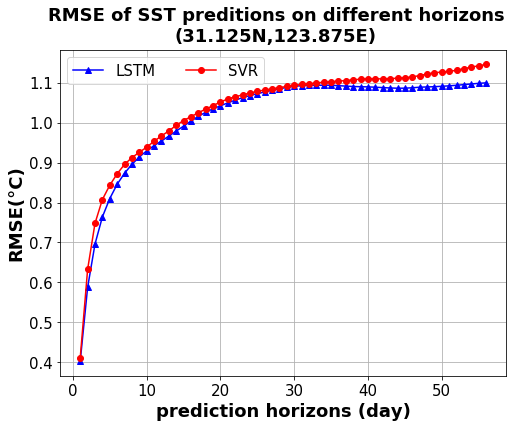

In [2348]:
# plot and compare statistics of N days ahead prediction using LSTM and SVR(RMSE)(English Version)
preds_horizons=[(i+1) for i in range(len(rmse_lstm_all))]

fig,ax=pyplot.subplots(figsize=(8,6))
fig.suptitle('RMSE of SST preditions on different horizons\n'+location,fontsize=18,fontweight='bold')

ax.plot(preds_horizons,rmse_lstm_all,'b^-',label='LSTM') 
ax.plot(preds_horizons,rmse_svr_all,'ro-',label='SVR') 

# set x,y label
ax.set_xlabel(xlabel='prediction horizons (day)',
              fontsize=18,
              fontweight='bold')
ax.set_ylabel(ylabel='RMSE(\u00B0C)',
              fontsize=18,
              fontweight='bold')
# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
legend=ax.legend(loc='upper left',fontsize=15,ncol=3)
#legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.825, 1.18))

# save fig
fig.savefig(resultsDir_en+'RMSE for prediction on different horizons using moving window '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()

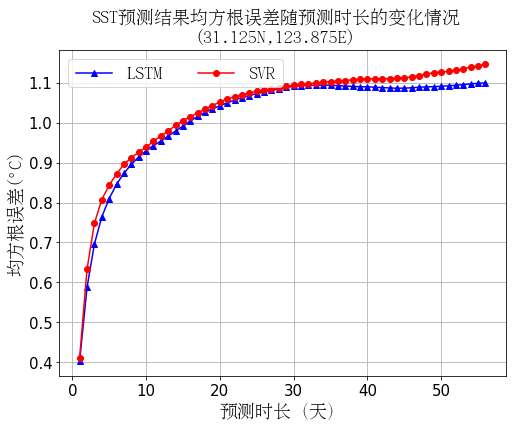

In [2349]:
# plot and compare statistics of N days ahead prediction using LSTM and SVR(RMSE)(Chinese Version)
preds_horizons=[(i+1) for i in range(len(rmse_lstm_all))]

fig,ax=pyplot.subplots(figsize=(8,6))
fig.suptitle('SST预测结果均方根误差随预测时长的变化情况\n'+location,fontproperties=zhfont)

ax.plot(preds_horizons,rmse_lstm_all,'b^-',label='LSTM') 
ax.plot(preds_horizons,rmse_svr_all,'ro-',label='SVR') 

# set x,y label
ax.set_xlabel(xlabel='预测时长（天）',fontproperties=zhfont)
ax.set_ylabel(ylabel='均方根误差(\u00B0C)',fontproperties=zhfont)
# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
legend=ax.legend(loc='upper left',ncol=3,prop=zhfont)
#legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.825, 1.18))

# save fig
fig.savefig(resultsDir_cn+'RMSE for prediction on different horizons using moving window '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()

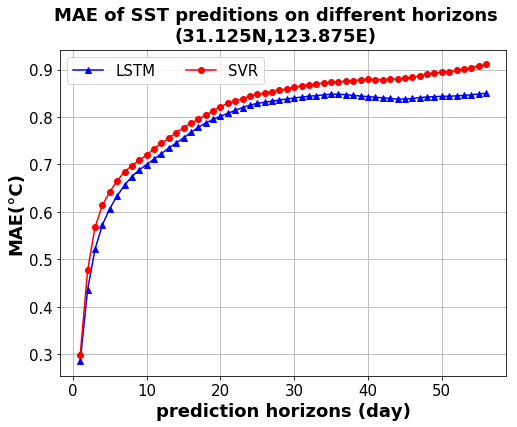

In [2350]:
# plot and compare statistics of N days ahead prediction using LSTM and SVR(MAE)(English version)
preds_horizons=[(i+1) for i in range(len(mae_lstm_all))]

fig,ax=pyplot.subplots(figsize=(8,6))
fig.suptitle('MAE of SST preditions on different horizons\n'+location,fontsize=18,fontweight='bold')

ax.plot(preds_horizons,mae_lstm_all,'b^-',label='LSTM') 
ax.plot(preds_horizons,mae_svr_all,'ro-',label='SVR') 

# set x,y label
ax.set_xlabel(xlabel='prediction horizons (day)',
              fontsize=18,
              fontweight='bold')
ax.set_ylabel(ylabel='MAE(\u00B0C)',
              fontsize=18,
              fontweight='bold')
# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
legend=ax.legend(loc='upper left',fontsize=15,ncol=3)
#legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.825, 1.18))

# save fig
fig.savefig(resultsDir_en+'MAE for prediction on different horizons using moving window '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()

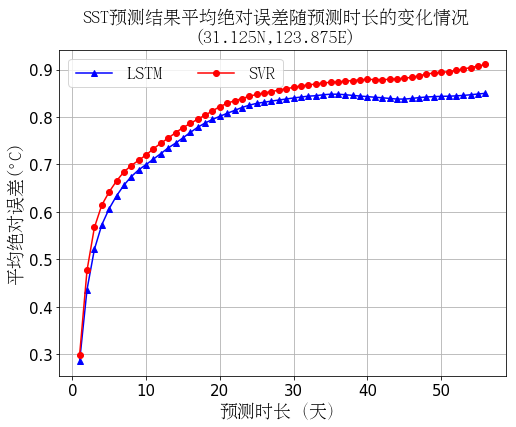

In [2351]:
# plot and compare statistics of N days ahead prediction using LSTM and SVR(MAE)(Chinese version)
preds_horizons=[(i+1) for i in range(len(mae_lstm_all))]

fig,ax=pyplot.subplots(figsize=(8,6))
fig.suptitle('SST预测结果平均绝对误差随预测时长的变化情况\n'+location,fontproperties=zhfont)

ax.plot(preds_horizons,mae_lstm_all,'b^-',label='LSTM') 
ax.plot(preds_horizons,mae_svr_all,'ro-',label='SVR') 

# set x,y label
ax.set_xlabel(xlabel='预测时长（天）',fontproperties=zhfont)
ax.set_ylabel(ylabel='平均绝对误差(\u00B0C)',fontproperties=zhfont)
# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
legend=ax.legend(loc='upper left',ncol=3,prop=zhfont)
#legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.825, 1.18))

# save fig
fig.savefig(resultsDir_cn+'MAE for prediction on different horizons using moving window '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()

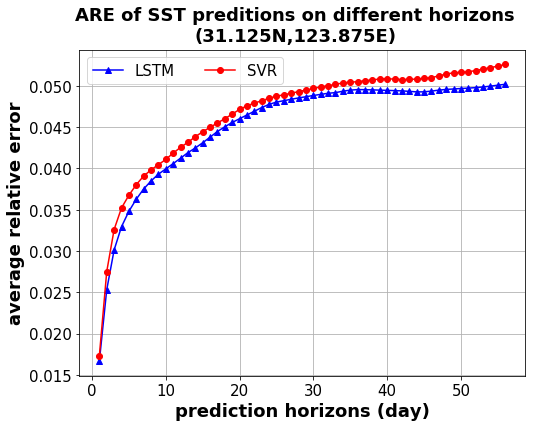

In [2352]:
# plot and compare statistics of N days ahead prediction using LSTM and SVR(ARE)(English version)
preds_horizons=[(i+1) for i in range(len(are_lstm_all))]

fig,ax=pyplot.subplots(figsize=(8,6))
fig.suptitle('ARE of SST preditions on different horizons\n'+location,fontsize=18,fontweight='bold')

ax.plot(preds_horizons,are_lstm_all,'b^-',label='LSTM') 
ax.plot(preds_horizons,are_svr_all,'ro-',label='SVR') 

# set x,y label
ax.set_xlabel(xlabel='prediction horizons (day)',
              fontsize=18,
              fontweight='bold')
ax.set_ylabel(ylabel='average relative error',
              fontsize=18,
              fontweight='bold')
# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
legend=ax.legend(loc='upper left',fontsize=15,ncol=3)
#legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.825, 1.18))

# save fig
fig.savefig(resultsDir_en+'ARE for prediction on different horizons using moving window '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()

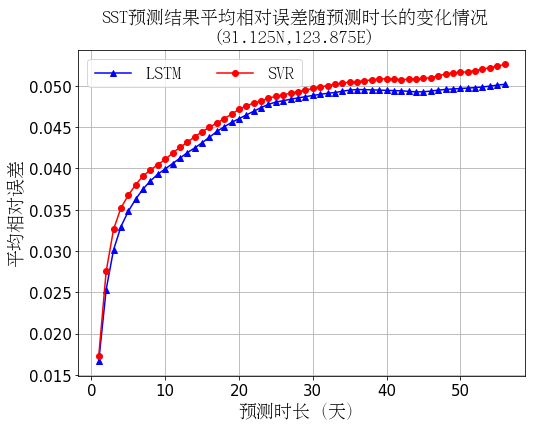

In [2353]:
# plot and compare statistics of N days ahead prediction using LSTM and SVR(ARE)(Chinese version)
preds_horizons=[(i+1) for i in range(len(are_lstm_all))]

fig,ax=pyplot.subplots(figsize=(8,6))
fig.suptitle('SST预测结果平均相对误差随预测时长的变化情况\n'+location,fontproperties=zhfont)

ax.plot(preds_horizons,are_lstm_all,'b^-',label='LSTM') 
ax.plot(preds_horizons,are_svr_all,'ro-',label='SVR') 

# set x,y label
ax.set_xlabel(xlabel='预测时长（天）',fontproperties=zhfont)
ax.set_ylabel(ylabel='平均相对误差',fontproperties=zhfont)
# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
legend=ax.legend(loc='upper left',ncol=3,prop=zhfont)
#legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.825, 1.18))

# save fig
fig.savefig(resultsDir_cn+'ARE for prediction on different horizons using moving window '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()

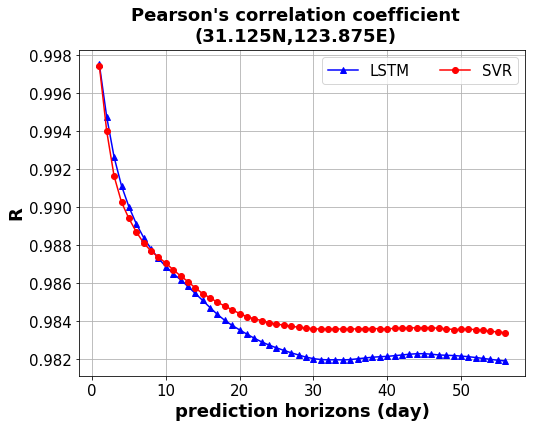

In [2354]:
# plot and compare statistics of N days ahead prediction using LSTM and SVR(R)(English version)
preds_horizons=[(i+1) for i in range(len(r_svr_all))]

fig,ax=pyplot.subplots(figsize=(8,6))
fig.suptitle('Pearson\'s correlation coefficient\n'+location,fontsize=18,fontweight='bold')

ax.plot(preds_horizons,r_lstm_all,'b^-',label='LSTM') 
ax.plot(preds_horizons,r_svr_all,'ro-',label='SVR')

# set x,y label
ax.set_xlabel(xlabel='prediction horizons (day)',
              fontsize=18,
              fontweight='bold')
ax.set_ylabel(ylabel='R',
              fontsize=18,
              fontweight='bold')
# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
legend=ax.legend(loc='upper right',fontsize=15,ncol=3)
#legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.825, 1.18))

# save fig
fig.savefig(resultsDir_en+'Pearson correlation coefficient for prediction on different horizons using moving window '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()

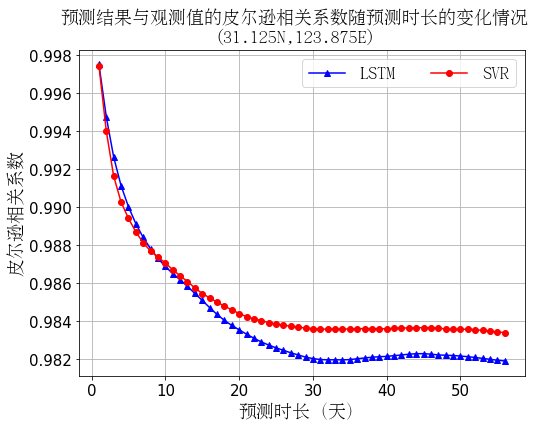

In [2355]:
# plot and compare statistics of N days ahead prediction using LSTM and SVR(R)(Chinese version)
preds_horizons=[(i+1) for i in range(len(r_svr_all))]

fig,ax=pyplot.subplots(figsize=(8,6))
fig.suptitle('预测结果与观测值的皮尔逊相关系数随预测时长的变化情况\n'+location,fontproperties=zhfont)

ax.plot(preds_horizons,r_lstm_all,'b^-',label='LSTM') 
ax.plot(preds_horizons,r_svr_all,'ro-',label='SVR')

# set x,y label
ax.set_xlabel(xlabel='预测时长（天）',fontproperties=zhfont)
ax.set_ylabel(ylabel='皮尔逊相关系数',fontproperties=zhfont)
# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
legend=ax.legend(loc='upper right',ncol=3,prop=zhfont)
#legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.825, 1.18))

# save fig
fig.savefig(resultsDir_cn+'Pearson correlation coefficient for prediction on different horizons using moving window '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()

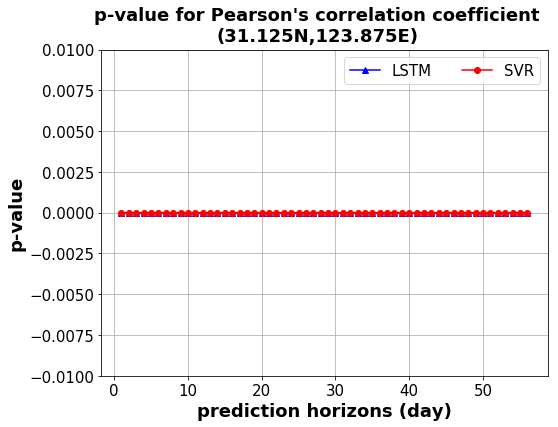

In [2356]:
# plot and compare statistics of N days ahead prediction using LSTM and SVR(p-value)(English version)
preds_horizons=[(i+1) for i in range(len(p_value_lstm_all))]

fig,ax=pyplot.subplots(figsize=(8,6))
fig.suptitle('p-value for Pearson\'s correlation coefficient\n'+location,fontsize=18,fontweight='bold')

ax.plot(preds_horizons,p_value_lstm_all,'b^-',label='LSTM') 
ax.plot(preds_horizons,p_value_svr_all,'ro-',label='SVR')

# set x,y label
ax.set_xlabel(xlabel='prediction horizons (day)',
              fontsize=18,
              fontweight='bold')
ax.set_ylabel(ylabel='p-value',
              fontsize=18,
              fontweight='bold')

# set axis range
ax.set_ylim([-0.01,0.01])

# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
legend=ax.legend(loc='upper right',fontsize=15,ncol=3)
#legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.825, 1.18))

# save fig
fig.savefig(resultsDir_en+'p-value for Pearson correlation coefficient for prediction on different horizons using moving window '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()

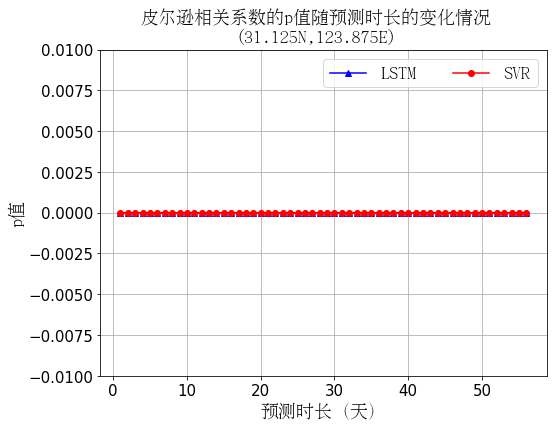

In [2357]:
# plot and compare statistics of N days ahead prediction using LSTM and SVR(p-value)(Chinese version)
preds_horizons=[(i+1) for i in range(len(p_value_lstm_all))]

fig,ax=pyplot.subplots(figsize=(8,6))
fig.suptitle('皮尔逊相关系数的p值随预测时长的变化情况\n'+location,fontproperties=zhfont)

ax.plot(preds_horizons,p_value_lstm_all,'b^-',label='LSTM') 
ax.plot(preds_horizons,p_value_svr_all,'ro-',label='SVR')

# set x,y label
ax.set_xlabel(xlabel='预测时长（天）',fontproperties=zhfont)
ax.set_ylabel(ylabel='p值',fontproperties=zhfont)

# set axis range
ax.set_ylim([-0.01,0.01])

# set tick labels
pyplot.setp(ax.get_xticklabels(),fontsize=15)
pyplot.setp(ax.get_yticklabels(),fontsize=15)
# add grid
ax.grid()
# add legend
legend=ax.legend(loc='upper right',ncol=3,prop=zhfont)
#legend=ax.legend(loc='upper left',fontsize=15, bbox_to_anchor=(0.825, 1.18))

# save fig
fig.savefig(resultsDir_cn+'p-value for Pearson correlation coefficient for prediction on different horizons using moving window '+location+'.eps',
            dpi=300,
            orientation='portrait',
            format='eps',
            bbox_inches = 'tight')
pyplot.show()